# Visualizing Corona Virus

> **Authors**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)
- [Peifan Wu *UBC*](https://economics.ubc.ca/faculty-and-staff/peifan-wu/)


**Prerequisites**

- [Data Visualization: Rules and Guidelines](visualization_rules.ipynb)  


**Outcomes**

- Visualize current data on Corona virus  

## Outline

- [Visualizing Corona Virus](#Visualizing-Corona-Virus)  
  - [Introduction](#Introduction)  
  - [Data](#Data)  
  - [Visualization](#Visualization)  
  - [More Detailed Data](#More-Detailed-Data)  
  - [Visualization, continued](#Visualization,-continued)  
  - [References](#References)  
  - [Exercises](#Exercises)  

In [22]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

## Introduction

This notebook works with daily data on Covid-19 cases by country and region.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Data

We will use data from [Johns Hopkins University Center for Systems
Science and
Engineering](https://github.com/CSSEGISandData/COVID-19) . It is
gathered from a variety of sources and updated daily. JHU CSSE uses
the data for [this interactive
website.](https://coronavirus.jhu.edu/map.html)

JHU CSSE has the data on github. It gets updated daily.

There are three csv files containing daily counts of confirmed cases,
recoveries, and deaths for each country (and provinces within some
countries).

In [24]:
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,170,174,237,273,281,299,349,367,423,444
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,223,243,259,277,304,333,361,377,383,400
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,584,716,847,986,1171,1251,1320,1423,1468,1572
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,370,376,390,428,439,466,501,525,545,564
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,7,8,8,8,10,14,16,17,19


The data comes in “wide” format with one row per area and different
dates in columns. Let’s reshape to “long” format with one country-date
combination per row and counts in a single column.

In [25]:
ids = ["Province/State","Country/Region", "Lat","Long"]
confirmed=confirmed.melt(id_vars=ids, var_name="Date", value_name="cases")
deaths=deaths.melt(id_vars=ids,var_name="Date", value_name="deaths")
recoveries=recoveries.melt(id_vars=ids,var_name="Date", value_name="recoveries")

We can now merge the confirmed cases, recoveries, and deaths into a
single data frame.

In [26]:
covid = pd.merge(confirmed, deaths, on=ids.append("Date"), how='outer')
covid = pd.merge(covid, recoveries, on=ids.append("Date"), how='left')

covid["Date"] = pd.to_datetime(covid["Date"])
covid["Province/State"]=covid["Province/State"].fillna("")

We can see the most recent data for Canada with the following.

In [27]:
covid.groupby("Country/Region").get_group("Canada").groupby("Province/State").tail(1)

,Province/State,Country/Region,Lat,Long,Date,cases,deaths,recoveries
20286,Alberta,Canada,53.9333,-116.5765,2020-04-08,1373,26,NaN
20287,British Columbia,Canada,49.2827,-123.1207,2020-04-08,1291,43,NaN
20288,Grand Princess,Canada,37.6489,-122.6655,2020-04-08,13,0,NaN
20289,Manitoba,Canada,53.7609,-98.8139,2020-04-08,217,3,NaN
20290,New Brunswick,Canada,46.5653,-66.4619,2020-04-08,105,0,NaN
20291,Newfoundland and Labrador,Canada,53.1355,-57.6604,2020-04-08,228,1,NaN
20292,Nova Scotia,Canada,44.6820,-63.7443,2020-04-08,310,1,NaN
20293,Ontario,Canada,51.2538,-85.3232,2020-04-08,5276,153,NaN
20294,Prince Edward Island,Canada,46.5107,-63.4168,2020-04-08,25,1,NaN
20295,Quebec,Canada,52.9399,-73.5491,2020-04-08,10031,175,NaN


## Visualization

Let’s make a couple figures showing the evolution of cases in Canada.

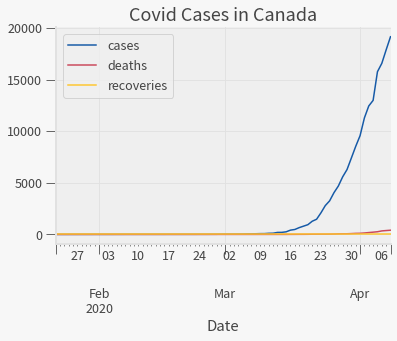

In [28]:
def countryplot(countryname):
    df=covid.groupby("Country/Region").get_group(countryname)
    ax = df.groupby("Date").sum().reset_index().plot(x='Date', y=["cases","deaths","recoveries"], title=f"Covid Cases in {countryname}")
    return(ax)

countryplot("Canada")

Text(0.5, 1.0, 'Cases by Province')

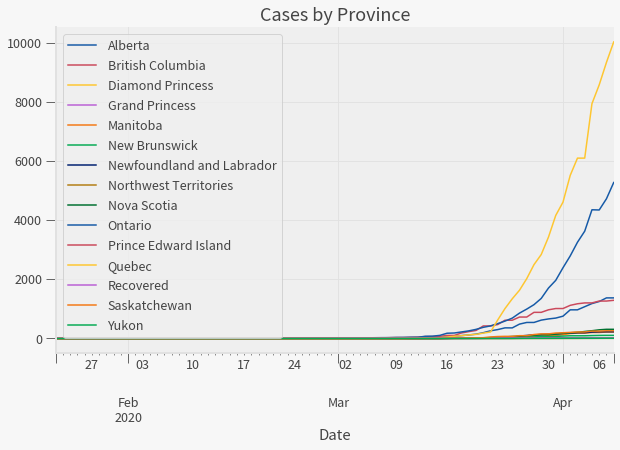

In [29]:
canada = covid.groupby("Country/Region").get_group("Canada")
fig, ax = plt.subplots(figsize=(10,6))
for prov, df in canada.reset_index().groupby("Province/State"):
    df.plot(x="Date",y="cases", ax=ax,label=prov)
ax.set_title("Cases by Province")


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)

### Comparing Confirmed Case Trajectories

Corona virus began its spread in different areas at different dates.

To compare the growth trajectory of confirmed cases across countries,
we will plot case counts vs the days since the number of cases in an
area reach 50.

In [30]:
# Create column with days since cases reached basecount
basecount=50
baseday = covid.query(f"cases>={basecount}").groupby(["Country/Region","Province/State"])["Date"].min().reset_index().rename(columns={"Date":"basedate"})
df = pd.merge(covid, baseday.reset_index(), on=["Country/Region","Province/State"])
df["dayssince"] = (df["Date"]-df["basedate"]).dt.days;

# To make the plot readable, we'll just show these countries
sdf=df[df["Country/Region"].isin(["Canada","China","Iran","Italy","France","US","Korea, South", "Spain", "United Kingdom"])];

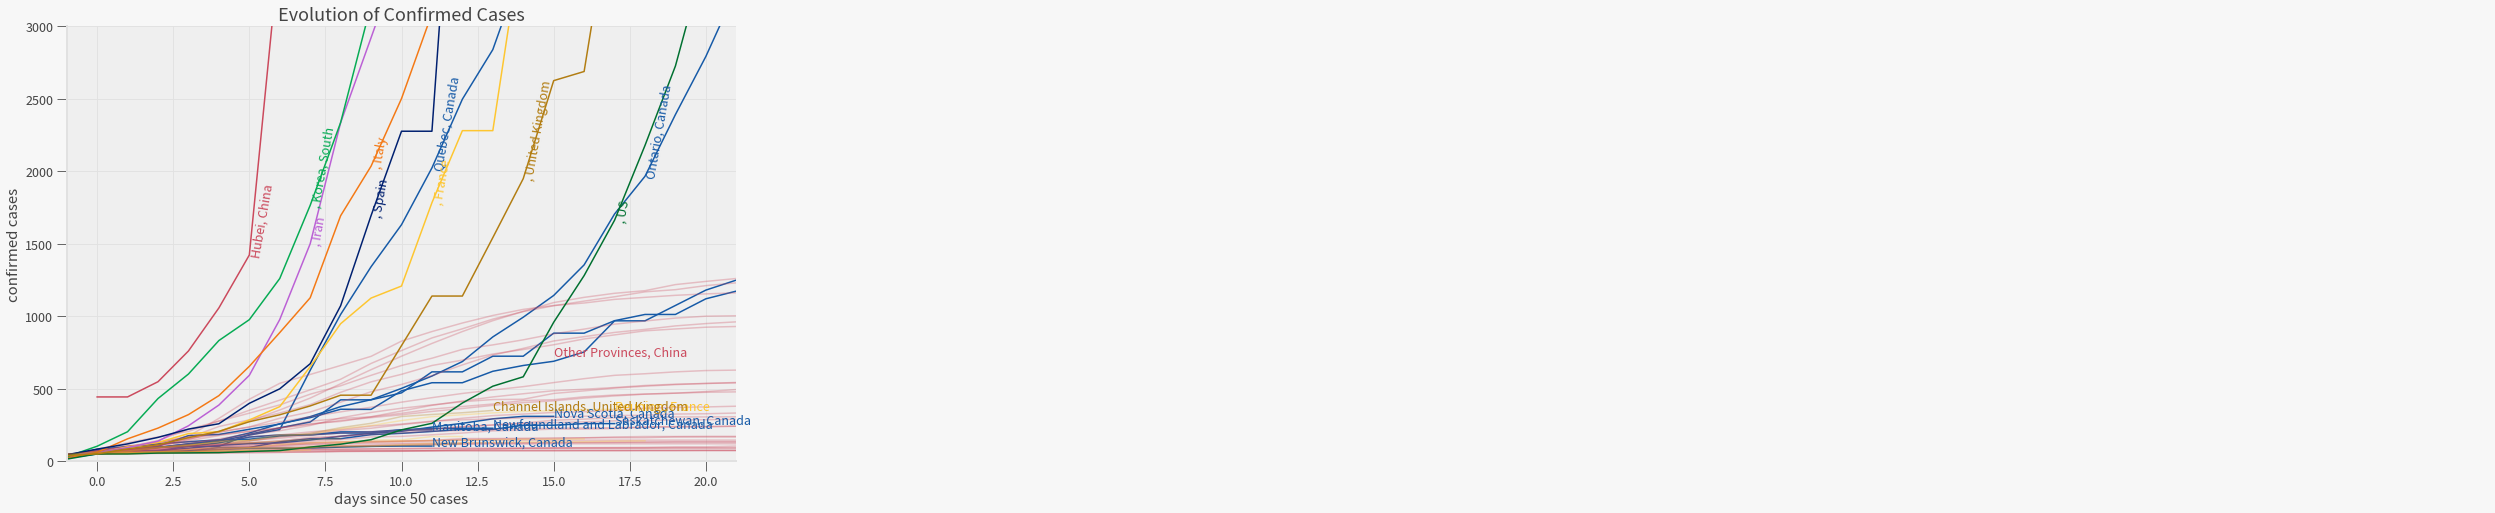

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

ymax = 3000
gdf=sdf.groupby(["Country/Region","Province/State"])
colors = qeds.themes.COLOR_CYCLE
cmap = dict(zip(sdf["Country/Region"].unique(), colors))
for k, g in gdf :
    alpha = 1.0 if k[0]=="Canada" or g["cases"].max()>3000 else 0.3
    g.plot(x="dayssince", y="cases", ax=ax, title="Evolution of Confirmed Cases", legend=False, color=cmap[k[0]], xlim=[-1, 21], ylim=[0,ymax], alpha=alpha)
    if g["cases"].max()>=ymax :
        y = ymax*.7
        x = g.query(f"cases<{y}")["dayssince"].max()
        y = g.query(f"dayssince>={x}")["cases"].min()
        ax.annotate(f"{k[1]}, {k[0]}",
        (x, y), rotation=80, color=cmap[k[0]])
    elif g["cases"].max()>=300 or (k[0]=="Canada" and g["cases"].max()>=100):
        x=g["dayssince"].max()
        y=g["cases"].max()
        ax.annotate(f"{k[1]}, {k[0]}", (x,y), color=cmap[k[0]], annotation_clip=True)

ax.annotate("Other Provinces, China", (15,730),color=cmap["China"])
ax.set_xlabel(f"days since {basecount} cases")
ax.set_ylabel("confirmed cases");

From these trajectories, we can get some idea of what might happen in
countries where the epidemic is in its early stages (like Canada) by
looking at what happened in countries where the epidemic is further
along (like China, South Korea, and Italy).

It can be helpful to helpful to look at a similar graph on a log
scale. Differences in logs are approximately equal to growth rates, so
the slopes on the graph below are the growth rates of cases.

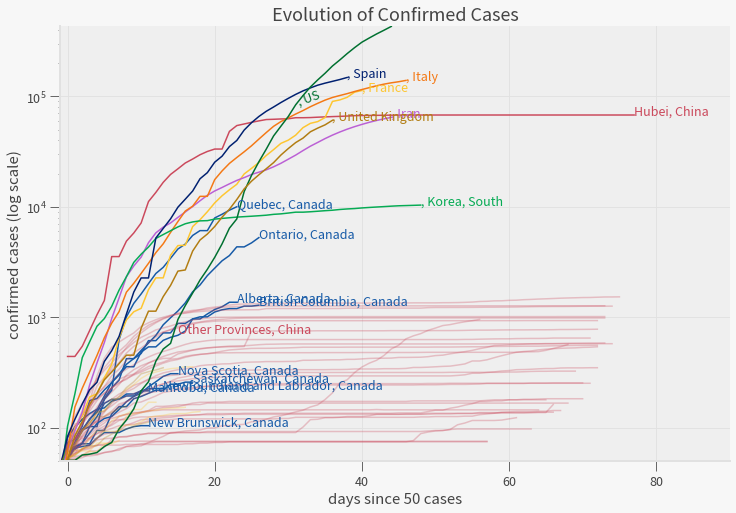

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ymax = covid["cases"].max()
xmax=90
for k, g in gdf :
    alpha = 1.0 if k[0]=="Canada" or g["cases"].max()>3000 else 0.3
    g.plot(x="dayssince", y="cases", ax=ax, title="Evolution of Confirmed Cases",
           legend=False, color=cmap[k[0]], xlim=[-1, 21], ylim=[0,ymax], alpha=alpha)
    if g["cases"].max()>=ymax :
        y = ymax*.2
        x = g.query(f"cases<{y}")["dayssince"].max()
        y = g.query(f"dayssince>={x}")["cases"].min()
        ax.annotate(f"{k[1]}, {k[0]}",
                    (x, y), rotation=20, color=cmap[k[0]])
    elif g["cases"].max()>=2000 or (k[0]=="Canada" and g["cases"].max()>=100):
        x=min(g["dayssince"].max(),xmax-5)
        y=g.query(f"dayssince>={x}")["cases"].min()
        ax.annotate(f"{k[1]}, {k[0]}", (x,y), color=cmap[k[0]], annotation_clip=True)

ax.annotate("Other Provinces, China", (15,730),color=cmap["China"])
ax.set_xlabel(f"days since {basecount} cases")
ax.set_ylabel("confirmed cases (log scale)");
ax.set_ylim((basecount,covid["cases"].max()))
ax.set_xlim((-1,xmax))
ax.set_yscale('log')

[This Financial Times article](https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441)
has some more polished figures looking at log cases.

### Mortality

We can get an estimate of the mortality rate by taking deaths divided
confirmed cases. If there are many unconfirmed cases, then we will be
overstating the mortality rate.

Medical care, population comorbidities, and testing availability vary
among countries. This can lead to differences in mortality rate per
confirmed case.

Here are the mortality rates per confirmed case in countries with at
least 50 deaths.

In [12]:
country=covid.groupby(["Country/Region","Date"]).sum()
latest=country.groupby("Country/Region").last().drop(columns=["Lat","Long"])
latest['mortalityrate'] = latest['deaths']/latest['cases']
latest.query('deaths>50')

,cases,deaths,recoveries,mortalityrate
Country/Region,,,,
Algeria,1572,205,237.0,0.130407
Argentina,1715,63,358.0,0.036735
Austria,12942,273,4512.0,0.021094
Belgium,23403,2240,4681.0,0.095714
Brazil,16170,819,127.0,0.050649
Canada,19141,407,0.0,0.021263
China,82809,3337,77567.0,0.040298
Colombia,2054,54,123.0,0.026290
Czechia,5312,99,233.0,0.018637


Below is a scatter plot of deaths vs cases. If the mortality rate were
the same across countries, then the points would all be on a line.

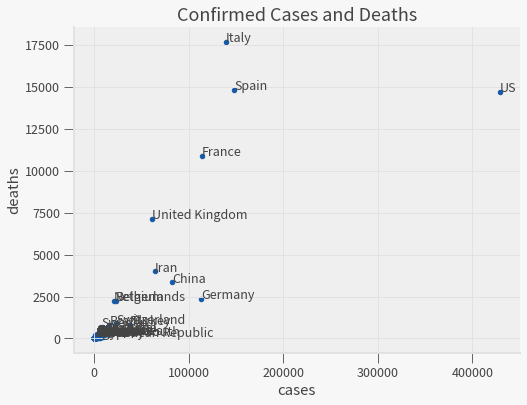

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
latest.plot(x="cases", y="deaths", kind="scatter",title="Confirmed Cases and Deaths", ax=ax)

for r in latest.query('deaths>=100').itertuples():
    ax.annotate(r.Index, (r.cases, r.deaths))

## More Detailed Data

China was the first country hit by COVID-19. After two months of lockdown,
there are almost no new cases anymore. Therefore we might learn more about
the complete COVID-19 epidemic dynamics by looking into Chinese panel data.

JHU CSSE collects data on province/state level for different countries
across the world which forms an unbalanced panel. In particular,
JHU CSSE gathered Chinese data from [DingXiangYuan](https://ncov.dxy.cn/ncovh5/view/en_pneumonia)
(DXY, it means “clove garden” in Chinese) starting from Jan 21st.
However, DXY manually collects more detailed prefecture- or city-level
data and some open-source web crawlers are updating these data every half
hour. We can utilize this panel data for further analysis.

In [14]:
# Use the city-level web crawler data form DingXiangYuan (DXY)
dt_china = pd.read_csv('https://raw.githubusercontent.com/BlankerL/DXY-COVID-19-Data/master/csv/DXYArea.csv')

# DXY collects data around the world but we use the Chinese data only
dt_china = dt_china[dt_china["countryEnglishName"] == "China"]
# Convert string to datetime
dt_china["updateTime"] = pd.to_datetime(dt_china["updateTime"])
# Drop NaN and unknown area reports on city level
dt_china = dt_china.dropna(subset = ["cityEnglishName"])
dt_china = dt_china[dt_china["cityEnglishName"] != "Area not defined"]

dt_china.head()

,continentName,continentEnglishName,countryName,countryEnglishName,provinceName,provinceEnglishName,province_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,updateTime,cityName,cityEnglishName,city_zipCode,city_confirmedCount,city_suspectedCount,city_curedCount,city_deadCount
104,亚洲,Asia,中国,China,辽宁省,Liaoning,210000,144,0.0,132,2,2020-04-09 20:08:14,大连,Dalian,210200.0,27.0,0.0,20.0,0.0
105,亚洲,Asia,中国,China,辽宁省,Liaoning,210000,144,0.0,132,2,2020-04-09 20:08:14,沈阳,Shenyang,210100.0,35.0,0.0,29.0,0.0
106,亚洲,Asia,中国,China,辽宁省,Liaoning,210000,144,0.0,132,2,2020-04-09 20:08:14,铁岭,Tieling,211200.0,9.0,0.0,7.0,0.0
107,亚洲,Asia,中国,China,辽宁省,Liaoning,210000,144,0.0,132,2,2020-04-09 20:08:14,鞍山,Anshan,210300.0,5.0,0.0,4.0,0.0
108,亚洲,Asia,中国,China,辽宁省,Liaoning,210000,144,0.0,132,2,2020-04-09 20:08:14,辽阳,Liaoyang,211000.0,4.0,0.0,3.0,0.0


Since DXY provides both Chinese and English webpages, the scraped data
consists of variables in both languages. We will use the English ones.
There are four variables of main interest: confirmed cases, suspected cases,
cases that are cured, and mortality.

## Visualization, continued

For most of the European and North American data we observe the expanding
trajectories. COVID-19 spreads out exponentially. We plot some similar
trajectories with Chinese data. Below we plot a trajectory for all cities
in the same province.

Text(0, 0.5, 'Persons')

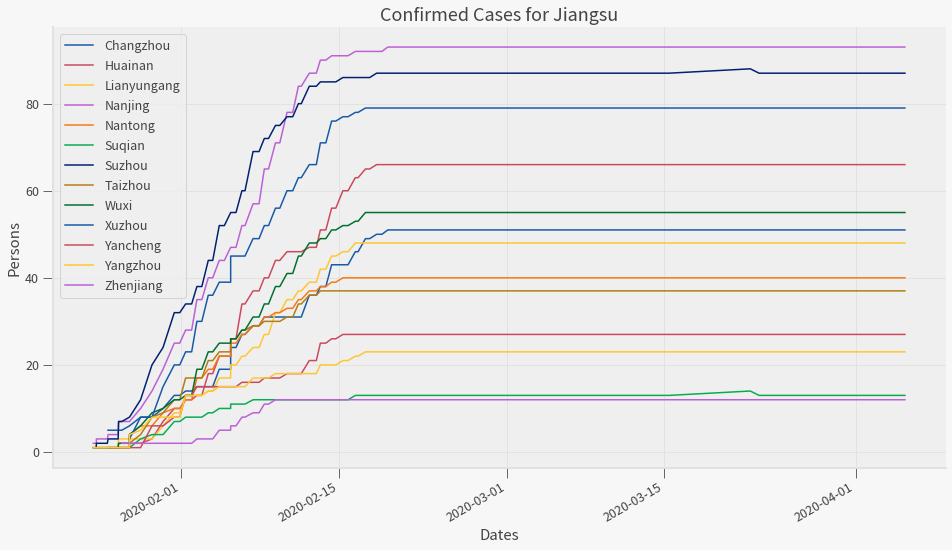

In [15]:
province_name = "Jiangsu" # For Jiangsu Province, you can change to "Hubei", "Shanghai", etc.
cur_province = dt_china.groupby("provinceEnglishName").get_group(province_name)
fig, ax = plt.subplots(figsize=(16,9))
for city, df in cur_province.reset_index().groupby("cityEnglishName"):
    df.plot(x="updateTime",y="city_confirmedCount", ax = ax, label = city)

# ax.legend().set_visible(False)
ax.set_title(f"Confirmed Cases for {province_name}")
ax.set_xlabel("Dates")
ax.set_ylabel("Persons")

We can see that the growth rate is high at the beginning, and then the growth
slows down. Eventually those trajectories converge, meaning that there are
no new confirmed cases any more.

Now let’s have a look at Hubei province (Wuhan is the capital of Hubei province
and most of the economic activities in Hubei are associated with Wuhan).

Text(0, 0.5, 'Persons')

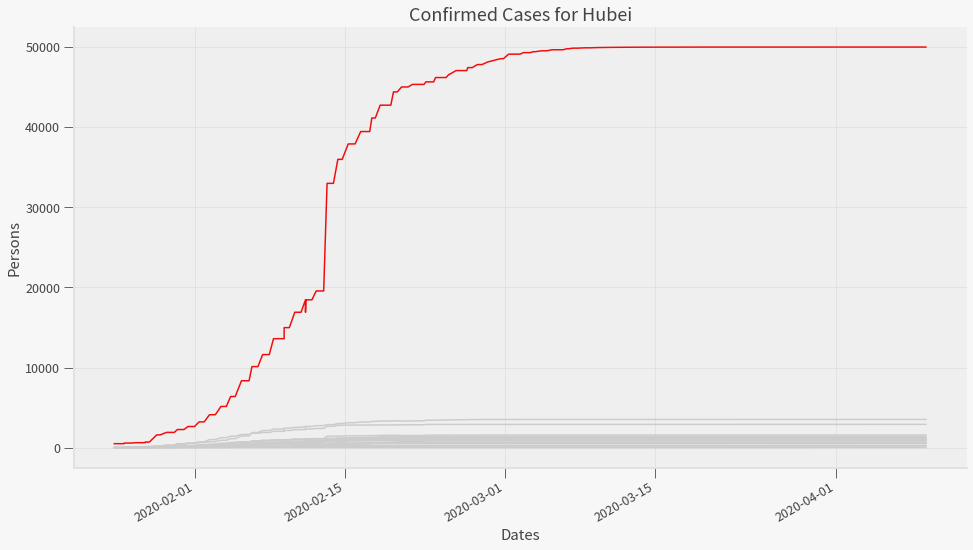

In [16]:
province_name = "Hubei"
cur_province = dt_china.groupby("provinceEnglishName").get_group(province_name)

# Use different color to emphasize
emp_color = (0.95, 0.05, 0.05)
nom_color = (0.8, 0.8, 0.8)

fig, ax = plt.subplots(figsize=(16,9))
for city, df in cur_province.reset_index().groupby("cityEnglishName"):
    if (city == "Wuhan"):
        cur_color = emp_color
    else:
        cur_color = nom_color
    df.plot(x="updateTime",y="city_confirmedCount", ax = ax, label = city, color = cur_color)

ax.legend().set_visible(False)
ax.set_title(f"Confirmed Cases for {province_name}")
ax.set_xlabel("Dates")
ax.set_ylabel("Persons")

Hubei stands out compared to other provinces from our previous graph, and
Wuhan stands out within Hubei province. Notice that there is a sudden jump
on Feb 13th. Do you know why? Wuhan starts lockdown from late January,
therefore the sudden jump doesn’t make much sense.

The reason behind this sudden jump is that the Chinese CDC changes its measure
for confirmed cases. Since COVID-19 lab tests take 2-3 days which might be
slow, the Chinese CDC includes all clinically diagnosed cases (mostly through
Computed Tomography scans) as confirmed cases. This measure overestimates the
confirmed cases by a small amount.

Therefore, a drastic change in data might be some interesting phenomenon,
but it could also be just a change in measurement.

### Curve in “Flatten the Curve”

You might have heard the phrase “flatten the curve” frequently these days.
In epidemiology, the idea of slowing a virus’ spread so that fewer people
need to seek treatment at any given time, which brings less burden to the
whole medical system. That’s why so many countries are implementing
“social distancing” and “shelter in place” orders.

To “flatten the curve”, we first analyze the curve itself. Essentially,
the curve characterizes how many confirmed cases that are not cured yet.

Text(0.5, 0, 'Time')

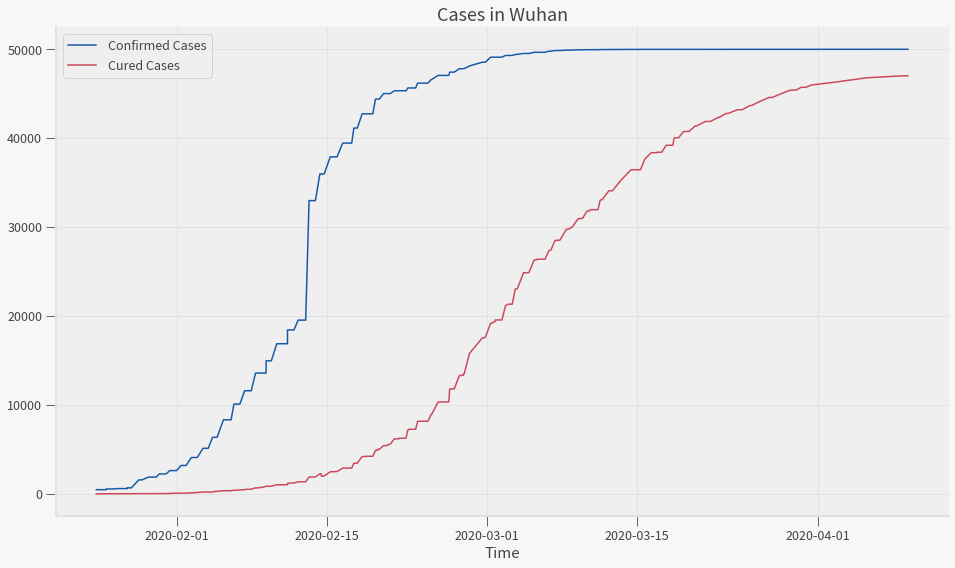

In [17]:
# Plot Wuhan out
dt_wuhan = dt_china[dt_china["cityEnglishName"] == "Wuhan"]
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(dt_wuhan["updateTime"], dt_wuhan["city_confirmedCount"], label = "Confirmed Cases")
ax.plot(dt_wuhan["updateTime"], dt_wuhan["city_curedCount"], label = "Cured Cases")

ax.legend()
ax.set_title('Cases in Wuhan')
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

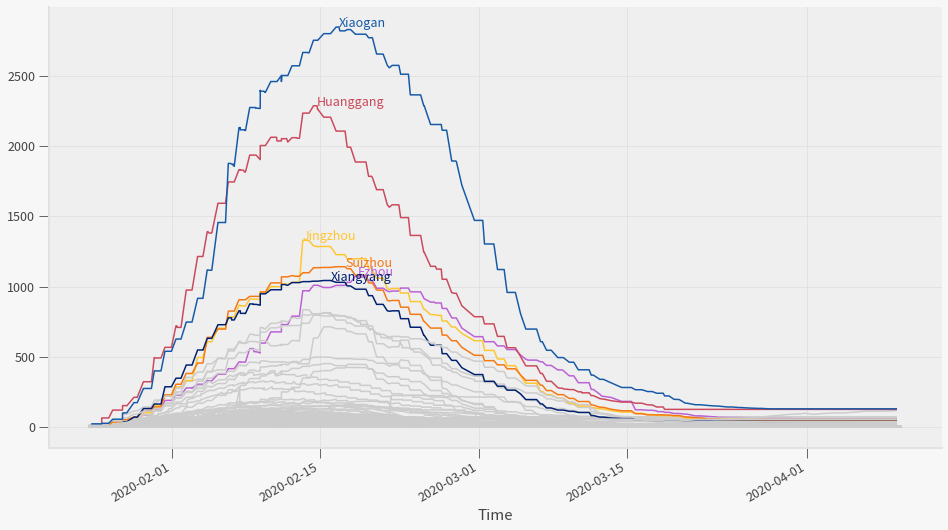

In [18]:
# Compute current cases
dt_china["city_current"] = dt_china["city_confirmedCount"] - dt_china["city_curedCount"]

colors = qeds.themes.COLOR_CYCLE
cmap = dict(zip(dt_china["cityEnglishName"].unique(), colors * (int(len(dt_china["cityEnglishName"].unique()) / 7) + 1)))
nom_color = (0.8, 0.8, 0.8)

fig, ax = plt.subplots(figsize=(16,9))
# dt_hubei = dt_china.groupby("provinceEnglishName").get_group("Hubei")
for city, df in dt_china.reset_index().groupby("cityEnglishName"):
    if (city != "Wuhan"):
        if (df["city_current"].max() >= 1000):
            df.plot(x="updateTime",y="city_current", ax = ax, label = city, color = cmap[city])
            y = df["city_current"].max()
            x = df["updateTime"][df["city_current"].idxmax()]
            ax.annotate(f"{city}", (x,y), color=cmap[city], annotation_clip=True)
        else:
            df.plot(x="updateTime",y="city_current", ax = ax, label = city, color = nom_color)

ax.legend().set_visible(False)
ax.set_xlabel("Time")


<a id='exercise-1'></a>
> See exercise 2 in the [*exercise list*](#exerciselist-0)

## References

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

Visualize the evolution of cases in other countries and their provinces or states.

In [19]:
# your code here

([*back to text*](#exercise-0))

**Exercise 2**

Plot the trajectory for all cities other than Wuhan in Hubei province.
Compare the magnitudes of confirmed cases in Hubei province to other
provinces (e.g. Jiangsu above)

In [20]:
# your code here

([*back to text*](#exercise-1))